<a href="https://colab.research.google.com/github/VihaShahh/AI_Intern/blob/main/Demo3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install qai-hub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 3.1 MB/s eta 0:00:00


In [4]:
!qai-hub configure --api_token 0bb7132654e37c476ab0375cc94e60a29def126b

qai-hub configuration saved to /root/.qai_hub/client.ini
==================== /root/.qai_hub/client.ini ====================
[api]
api_token = 0bb7132654e37c476ab0375cc94e60a29def126b
api_url = https://app.aihub.qualcomm.com
web_url = https://app.aihub.qualcomm.com
verbose = True




In [5]:
!qai-hub list-devices

+-------------------------------+------------+----------+---------+---------------------------------------+---------------------------------------------------------+
|             Device            |     OS     |  Vendor  |   Type  |                Chipset                |                      CLI Invocation                     |
+-------------------------------+------------+----------+---------+---------------------------------------+---------------------------------------------------------+
|    Google Pixel 3 (Family)    | Android 10 |  Google  |  Phone  |    qualcomm-snapdragon-845, sdm845    |    --device "Google Pixel 3 (Family)" --device-os 10    |
|         Google Pixel 3        | Android 10 |  Google  |  Phone  |    qualcomm-snapdragon-845, sdm845    |         --device "Google Pixel 3" --device-os 10        |
|        Google Pixel 3a        | Android 10 |  Google  |  Phone  |    qualcomm-snapdragon-670, sdm670    |        --device "Google Pixel 3a" --device-os 10        |
|   

In [6]:
pip install "qai-hub[torch]"

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [7]:
import qai_hub as hub
import torch
from torchvision.models import mobilenet_v2
import requests
import numpy as np
from PIL import Image

# Using pre-trained MobileNet
torch_model = mobilenet_v2(pretrained=True)
torch_model.eval()

# Step 1: Trace model
input_shape = (1, 3, 224, 224)
example_input = torch.rand(input_shape)
traced_torch_model = torch.jit.trace(torch_model, example_input)

# Step 2: Compile model for Xiaomi 12
compile_job = hub.submit_compile_job(
    model=traced_torch_model,
    device=hub.Device("Xiaomi 12"),
    input_specs=dict(image=input_shape),
)

# Step 3: Profile on cloud-hosted device (Xiaomi 12)
target_model = compile_job.get_target_model()
profile_job = hub.submit_profile_job(
    model=target_model,
    device=hub.Device("Xiaomi 12"),
)

# Step 4: Run inference on cloud-hosted device
sample_image_url = (
    "https://qaihub-public-assets.s3.us-west-2.amazonaws.com/apidoc/input_image1.jpg"
)
response = requests.get(sample_image_url, stream=True)
response.raw.decode_content = True
image = Image.open(response.raw).resize((224, 224))
input_array = np.expand_dims(
    np.transpose(np.array(image, dtype=np.float32) / 255.0, (2, 0, 1)), axis=0
)

# Run inference using the on-device model on the input image
inference_job = hub.submit_inference_job(
    model=target_model,
    device=hub.Device("Xiaomi 12"),
    inputs=dict(image=[input_array]),
)
on_device_output = inference_job.download_output_data()

# Step 5: Post-processing the on-device output
output_name = list(on_device_output.keys())[0]
out = on_device_output[output_name][0]
on_device_probabilities = np.exp(out) / np.sum(np.exp(out), axis=1)

# Read the class labels for imagenet
sample_classes = "https://qaihub-public-assets.s3.us-west-2.amazonaws.com/apidoc/imagenet_classes.txt"
response = requests.get(sample_classes, stream=True)
response.raw.decode_content = True
categories = [str(s.strip()) for s in response.raw]

# Print top five predictions for the on-device model
print("Top-5 On-Device predictions:")
top5_classes = np.argsort(on_device_probabilities[0], axis=0)[-5:]
for c in reversed(top5_classes):
    print(f"{c} {categories[c]:20s} {on_device_probabilities[0][c]:>6.1%}")

# Step 6: Download model
target_model = compile_job.get_target_model()
target_model.download("mobilenet_v2.tflite")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 94.3MB/s]
Uploading model: 100%|██████████| 13.9M/13.9M [00:01<00:00, 11.8MB/s]


Scheduled compile job (jep2d3dm5) successfully. To see the status and results:
    https://app.aihub.qualcomm.com/jobs/jep2d3dm5/

Waiting for compile job (jep2d3dm5) completion. Type Ctrl+C to stop waiting at any time.
    ✅ SUCCESS                          
Scheduled profiling job (jqpy2v24g) successfully. To see the status and results:
    https://app.aihub.qualcomm.com/jobs/jqpy2v24g/



Uploading dataset: 100%|██████████| 150k/150k [00:00<00:00, 268kB/s]


Scheduled inference job (j2p09e9ep) successfully. To see the status and results:
    https://app.aihub.qualcomm.com/jobs/j2p09e9ep/

Waiting for inference job (j2p09e9ep) completion. Type Ctrl+C to stop waiting at any time.
    ✅ SUCCESS                          


dataset-dv91vnqn9.h5: 100%|██████████| 14.5k/14.5k [00:00<00:00, 7.09MB/s]


Top-5 On-Device predictions:
968 b'cup'                70.9%
504 b'coffee mug'         16.6%
967 b'espresso'            7.9%
809 b'soup bowl'           1.4%
659 b'mixing bowl'         1.3%


job_jep2d3dm5_optimized_tflite_mzmx4e82q.tflite: 100%|██████████| 13.3M/13.3M [00:01<00:00, 13.6MB/s]


'mobilenet_v2.tflite'

In [11]:
%run -m qai_hub_models.models.ffnet_40s.export -- --device "Xiaomi 12"

100%|██████████| 55.8M/55.8M [00:01<00:00, 52.9MB/s]


Done
cityscapes_segmentation requires repository https://github.com/Qualcomm-AI-research/FFNet.git . Ok to clone? [Y/n] Y
Cloning https://github.com/Qualcomm-AI-research/FFNet.git to /root/.qaihm/models/cityscapes_segmentation/v2/Qualcomm-AI-research_FFNet_git...
Done
Loading pretrained model state dict from /root/.qaihm/models/ffnet/v1/ffnet40S/ffnet40S_dBBB_cityscapes_state_dict_quarts.pth
Initializing ffnnet40S_dBBB_mobile weights
Optimizing model ffnet_40s to run on-device


Uploading model: 100%|██████████| 53.6M/53.6M [00:13<00:00, 4.08MB/s]


Scheduled compile job (j1gl8e8lp) successfully. To see the status and results:
    https://app.aihub.qualcomm.com/jobs/j1gl8e8lp/

Profiling model ffnet_40s on a hosted device.
Waiting for compile job (j1gl8e8lp) completion. Type Ctrl+C to stop waiting at any time.
    ✅ SUCCESS                          
Scheduled profiling job (jw56mqm7p) successfully. To see the status and results:
    https://app.aihub.qualcomm.com/jobs/jw56mqm7p/

Running inference for ffnet_40s on a hosted device with example inputs.


Uploading dataset: 100%|██████████| 21.5M/21.5M [00:01<00:00, 15.6MB/s]


Scheduled inference job (j1p37q7zg) successfully. To see the status and results:
    https://app.aihub.qualcomm.com/jobs/j1p37q7zg/



job_j1gl8e8lp_optimized_tflite_mkq3o609q.tflite: 100%|██████████| 53.1M/53.1M [00:02<00:00, 21.1MB/s]


Waiting for profile job (jw56mqm7p) completion. Type Ctrl+C to stop waiting at any time.
    ✅ SUCCESS                          

------------------------------------------------------------
Performance results on-device for Ffnet_40S.
------------------------------------------------------------
Device                          : Xiaomi 12 (12)
Runtime                         : TFLITE        
Estimated inference time (ms)   : 37.0          
Estimated peak memory usage (MB): [2, 19]       
Total # Ops                     : 92            
Compute Unit(s)                 : NPU (92 ops)  
------------------------------------------------------------
More details: https://app.aihub.qualcomm.com/jobs/jw56mqm7p/



dataset-dk7gzegy2.h5: 100%|██████████| 1.22M/1.22M [00:00<00:00, 3.01MB/s]



Comparing on-device vs. local-cpu inference for Ffnet_40S.
+---------------+-------------------+--------+
| output_name   | shape             |   psnr |
+===============+===================+========+
| mask          | (1, 128, 256, 19) |  66.24 |
+---------------+-------------------+--------+

- psnr: Peak Signal-to-Noise Ratio (PSNR). >30 dB is typically considered good.

More details: https://app.aihub.qualcomm.com/jobs/j1p37q7zg/

Run compiled model on a hosted device on sample data using:
python /usr/local/lib/python3.10/dist-packages/qai_hub_models/models/ffnet_40s/demo.py --on-device --hub-model-id mkq3o609q --device "Xiaomi 12"



In [10]:
pip install qai_hub_models

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 3.2 MB/s eta 0:00:00
  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 24.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.3/401.3 kB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 798.3/798.3 kB 34.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 89.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.0/17.0 MB 83.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 85.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 MB 

100%|██████████| 443k/443k [00:00<00:00, 1.46MB/s]


Done
Compiling on-device model asset for ffnet_40s.
Running python -m qai_hub_models.models.ffnet_40s.export --device Xiaomi 12 --target-runtime tflite

Loading pretrained model state dict from /root/.qaihm/models/ffnet/v1/ffnet40S/ffnet40S_dBBB_cityscapes_state_dict_quarts.pth
Initializing ffnnet40S_dBBB_mobile weights
Optimizing model ffnet_40s to run on-device


Uploading model: 100%|██████████| 53.6M/53.6M [00:02<00:00, 23.1MB/s]


Scheduled compile job (jlpex4x0g) successfully. To see the status and results:
    https://app.aihub.qualcomm.com/jobs/jlpex4x0g/

Waiting for compile job (jlpex4x0g) completion. Type Ctrl+C to stop waiting at any time.
    ✅ SUCCESS                          
Exported asset: ffnet_40s

Running Inference on 0 samples


Uploading dataset: 100%|██████████| 7.42M/7.42M [00:01<00:00, 6.89MB/s]


Scheduled inference job (jygzyvy6p) successfully. To see the status and results:
    https://app.aihub.qualcomm.com/jobs/jygzyvy6p/

Waiting for inference job (jygzyvy6p) completion. Type Ctrl+C to stop waiting at any time.
    ✅ SUCCESS                          


dataset-dw9v4nxm9.h5: 100%|██████████| 1.32M/1.32M [00:00<00:00, 3.06MB/s]


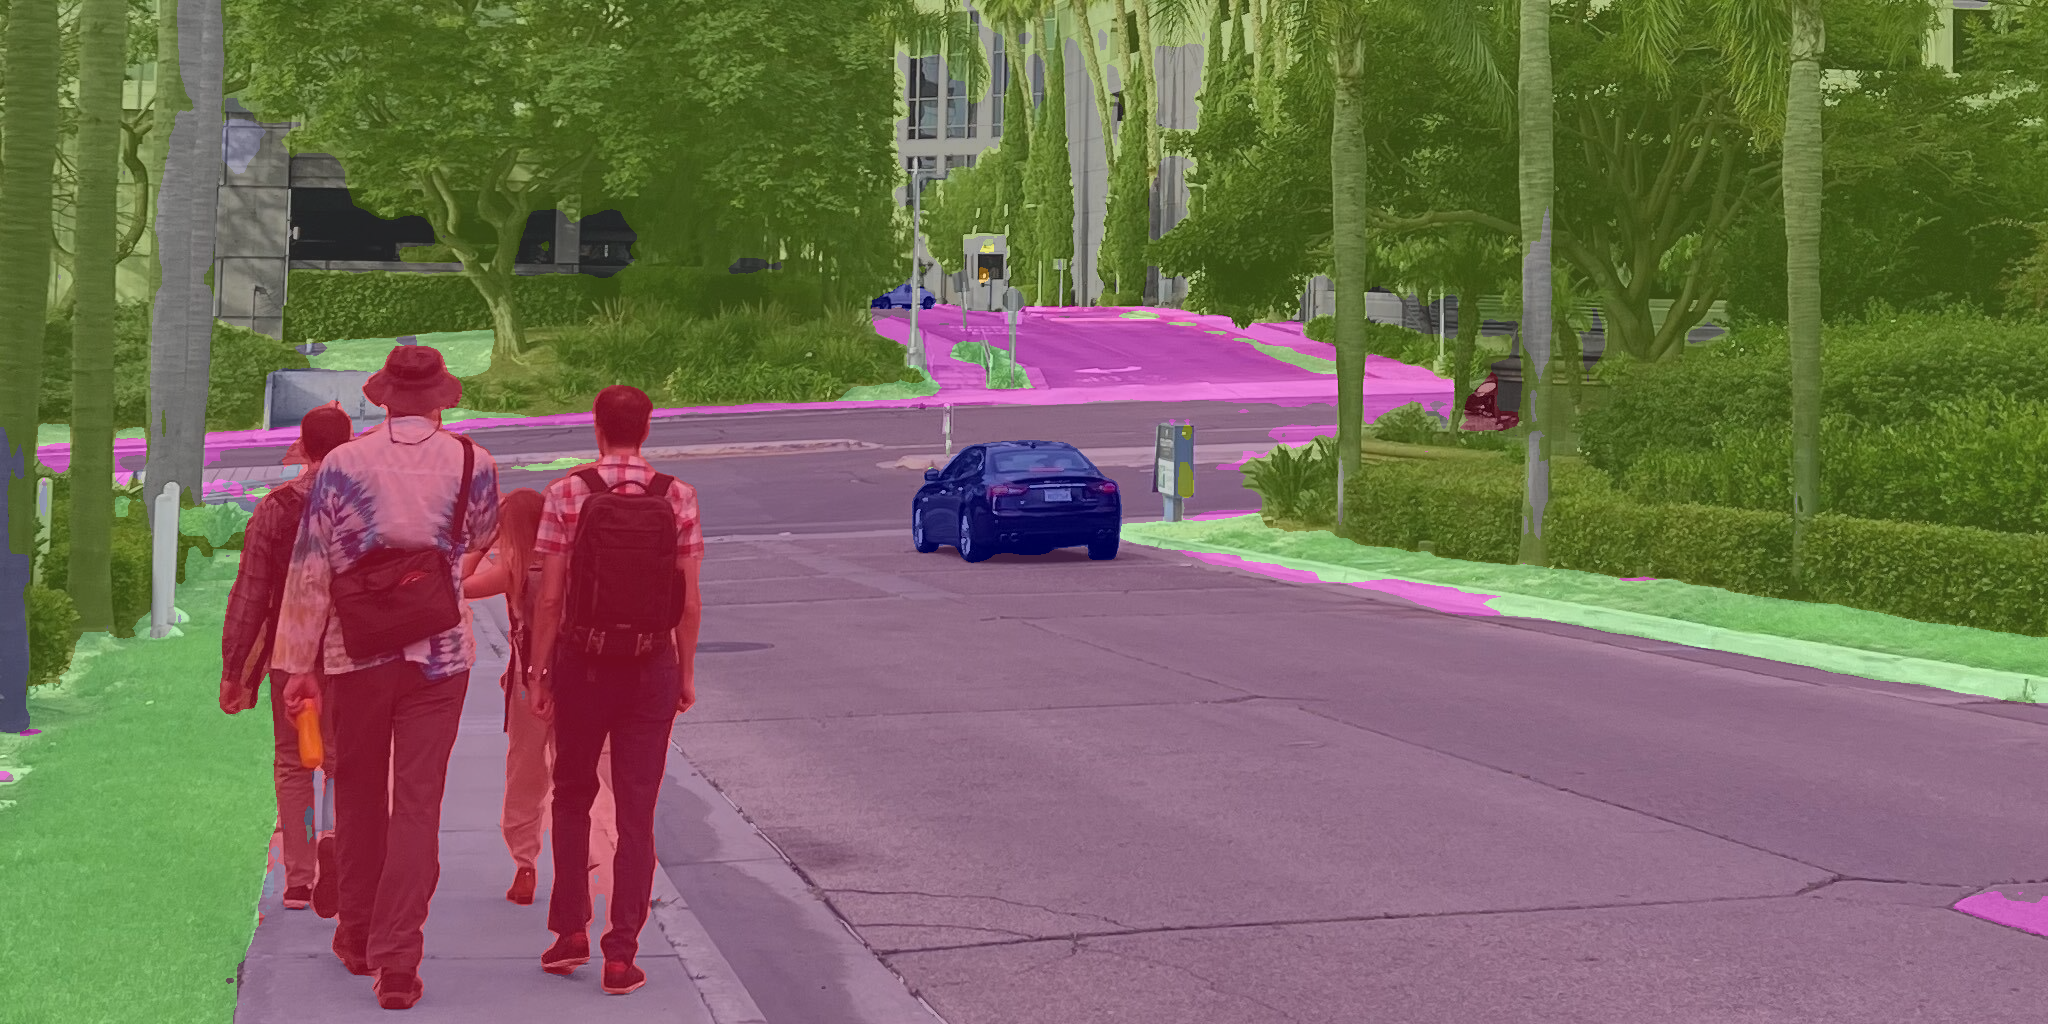

In [12]:
%run -m qai_hub_models.models.ffnet_40s.demo -- --device "Xiaomi 12" --on-device